# Kiran Final Data
## NutriNet: Maya Coronado, Savannah Gourley, Xander Lee, Kiran Rao
For some of my contributions to our Urb Pln final, I will be making an interactive map with all the tracts that had 0% Low Birth Weight to track how different tracts may have data missing or simply some tracts do not have any low birth weights. I will also be pulling some statistical tables to use for our Community Stories StoryMap, as well as deriving a type of index looking at different indicators we are working with. 

From here until about halfway down, I am replicating our processes that we derived to calculate the amount of SNAP acceptors per census tract. 

In [4]:
# to read and wrangle data
import pandas as pd
import numpy as np

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

import folium

In [5]:
df = pd.read_csv('data/Main Data.csv')
censusdata = gpd.read_file('data/Census_Tracts_2020.geojson')

In [6]:
df.columns

Index(['Unnamed: 0', 'tract', 'census tract', 'sup_dist', 'csa', 'spa',
       'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent'],
      dtype='object')

In [7]:
df.columns = ['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa',
       'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent']
df.columns

Index(['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa', 'ESRI_OID',
       'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent'],
      dtype='object')

In [8]:
df['census tract']='0'+ df['tract'].apply(str)

In [9]:
df.head()

Unnamed: 0      ignore       tract    sup_dist                         csa  \
0           0  6037980009  6037980009  District 5     Los Angeles - Los Feliz   
1           0  6037207307  6037207307  District 1      Los Angeles - Downtown   
2           0  6037207305  6037207305  District 1      Los Angeles - Downtown   
3           0  6037209202  6037209202  District 1      Los Angeles - Westlake   
4           0  6037216301  6037216301  District 2  Los Angeles - Miracle Mile   

             spa  ESRI_OID   Shape__Area  Shape__Length  Total Woman 15-50  \
0  SPA 4 - Metro      4427  2.284265e+08   78138.601740                  5   
1  SPA 4 - Metro      2493  5.271600e+05    2910.616691                400   
2  SPA 4 - Metro      2491  2.182715e+06    8262.438640                246   
3  SPA 4 - Metro      2611  2.667667e+06    6511.253069                459   
4  SPA 4 - Metro      2793  6.049547e+06   11309.816320                204   

   ...  Fertility Rate  Low Birth Weight  Low Birth Weight Pctl  \
0  ...        0.000000               0.0                    0.0   
1  ...        0.000000               0.0                    0.0   
2  ...        0.000000               0.0                    0.0   
3  ...        0.056645               0.0                    0.0   
4  ...        0.063725               0.0                    0.0   

   Average income  Grocery Store Low Access  \
0             NaN                       0.0   
1         12283.0                       0.0   
2         72330.0                       0.0   
3         36188.0                       0.0   
4             NaN                       0.0   

   Grocery Store Low Access Proportion  CalFresh Cases  CF cases per 100  \
0                                  0.0             1.0               0.0   
1                                  0.0           453.0             415.6   
2                                  0.0           108.0              73.5   
3                                  0.0           131.0              41.6   
4                                  0.0            57.0              14.7   

   PoCPercent  census tract  
0        0.48   06037980009  
1        0.62   06037207307  
2        0.37   06037207305  
3        0.76   06037209202  
4        0.21   06037216301  

[5 rows x 23 columns]

In [10]:
censusdata.head()

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
0         1  101110  1011.10  1.229562e+07   15083.854287   
1         2  101122  1011.22  2.845774e+07   31671.455844   
2         3  101220  1012.20  7.522093e+06   12698.783810   
3         4  101221  1012.21  3.812000e+06    9161.710543   
4         5  101222  1012.22  3.191371e+06    9980.600461   

                                            geometry  
0  POLYGON ((-118.28491 34.25948, -118.28492 34.2...  
1  POLYGON ((-118.29015 34.27417, -118.29015 34.2...  
2  POLYGON ((-118.28100 34.25592, -118.28198 34.2...  
3  POLYGON ((-118.28735 34.25591, -118.28863 34.2...  
4  POLYGON ((-118.28594 34.25405, -118.28594 34.2...

In [11]:
censusdata['census tract']='06' + '037' + censusdata ['CT20']

In [12]:
LBW=censusdata.merge(df,on="census tract")

In [13]:
SPA=gpd.read_file('data/Service_Planning_Areas_2022_(view).geojson')

In [14]:
selected_SPAs = SPA[SPA['LABEL'].isin(['SPA 4','SPA 5'])]

In [15]:
our_SPA=gpd.GeoDataFrame(selected_SPAs)

In [16]:
SNAP= pd.read_csv('data/SNAP_Retailer_Location_data.csv')

In [17]:
SNAP.shape

(8132, 17)

In [18]:
SNAP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     8132 non-null   float64
 1   Y                     8132 non-null   float64
 2   Record_ID             8132 non-null   int64  
 3   Store_Name            8132 non-null   object 
 4   Store_Street_Address  8132 non-null   object 
 5   Additonal_Address     746 non-null    object 
 6   City                  8132 non-null   object 
 7   State                 8132 non-null   object 
 8   Zip_Code              8132 non-null   int64  
 9   Zip4                  8132 non-null   object 
 10  County                8132 non-null   object 
 11  Store_Type            8132 non-null   object 
 12  Latitude              8132 non-null   float64
 13  Longitude             8132 non-null   float64
 14  Incentive_Program     89 non-null     object 
 15  Grantee_Name         

In [19]:
SNAP = gpd.GeoDataFrame(SNAP, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(SNAP.X, SNAP.Y))

In [20]:
SNAP_clip = gpd.clip(SNAP, our_SPA)

In [21]:
SNAP_clip = SNAP_clip.to_crs(epsg=3857)

In [22]:
#fig,ax = plt.subplots(figsize=(12,12))
#SNAP_clip.plot(ax=ax,
#             color='red',
#             markersize=10,
#              alpha=0.2)

# no axis
#ax.axis('off')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [23]:
minx, miny, maxx, maxy = SNAP_clip.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13225808.588623803
-13153034.58471261
4017685.127765333
4048354.4142391556


In [24]:
LBW.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   OBJECTID                             537 non-null    int64   
 1   CT20                                 537 non-null    object  
 2   LABEL                                537 non-null    object  
 3   ShapeSTArea                          537 non-null    float64 
 4   ShapeSTLength                        537 non-null    float64 
 5   geometry                             537 non-null    geometry
 6   census tract                         537 non-null    object  
 7   Unnamed: 0                           537 non-null    int64   
 8   ignore                               537 non-null    int64   
 9   tract                                537 non-null    int64   
 10  sup_dist                             537 non-null    object  
 11  csa        

Here, we are going to put our SNAP retailers coordinates on top of our map that is displaying rates of Low Birth Weight. 

In [25]:
LBW = LBW.to_crs(epsg=3857)

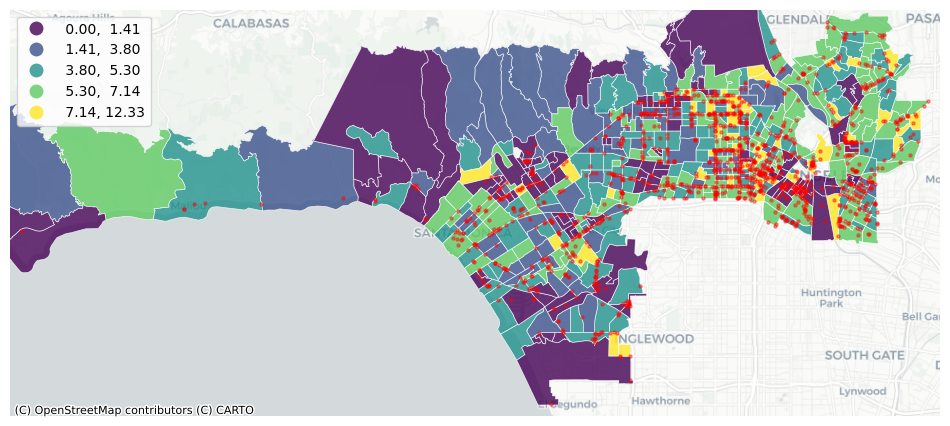

In [26]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='Low Birth Weight', 
         scheme='naturalbreaks',
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

From here, I aim to combine our SNAP retailers per tract data with our base data. 

In [28]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent'],
      dtype='object')

In [29]:
SNAP_clip.columns

Index(['X', 'Y', 'Record_ID', 'Store_Name', 'Store_Street_Address',
       'Additonal_Address', 'City', 'State', 'Zip_Code', 'Zip4', 'County',
       'Store_Type', 'Latitude', 'Longitude', 'Incentive_Program',
       'Grantee_Name', 'ObjectId', 'geometry'],
      dtype='object')

In [30]:
join = gpd.sjoin(LBW, SNAP_clip, how='left')

In [31]:
join.shape

(1503, 47)

In [32]:
join.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'index_right', 'X', 'Y', 'Record_ID',
       'Store_Name', 'Store_Street_Address', 'Additonal_Address', 'City',
       'State', 'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude',
       'Longitude', 'Incentive_Program', 'Grantee_Name', 'ObjectId'],
      dtype='object')

In [33]:
join.columns =['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census_tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'index_right', 'X', 'Y', 'Record_ID',
       'Store_Name', 'Store_Street_Address', 'Additonal_Address', 'City',
       'State', 'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude',
       'Longitude', 'Incentive_Program', 'Grantee_Name', 'ObjectId']

In [34]:
SNAP_by_tract = join.census_tract.value_counts().rename_axis('census_tract').reset_index(name='SNAP_count')


In [35]:
SNAP_by_tract.columns

Index(['census_tract', 'SNAP_count'], dtype='object')

Here I am going to look at data by tract to conceptualize distributions of retailers through SPA 4 & SPA 5. 

<Axes: xlabel='census_tract'>

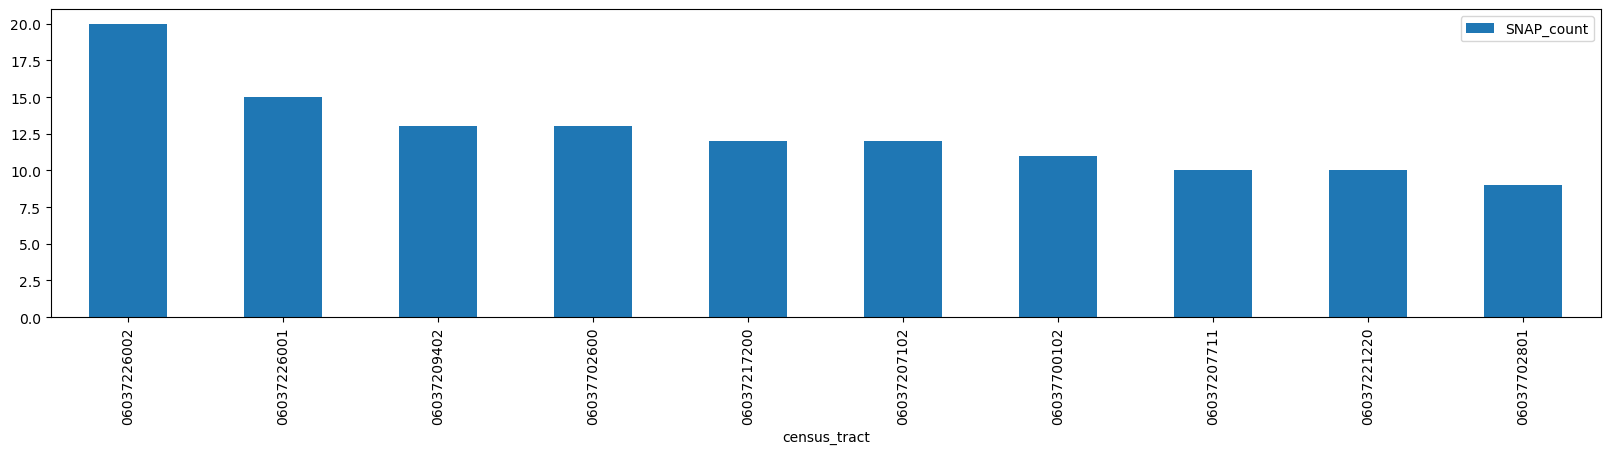

In [39]:
SNAP_by_tract[:10].plot.bar(figsize=(20,4),
                             x='census_tract',
                             y='SNAP_count')

{'whiskers': [<matplotlib.lines.Line2D at 0x7e523368a310>,
 'caps': [<matplotlib.lines.Line2D at 0x7e523368b650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e52337b8a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7e523369c750>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e523369cfd0>],
 'means': []}

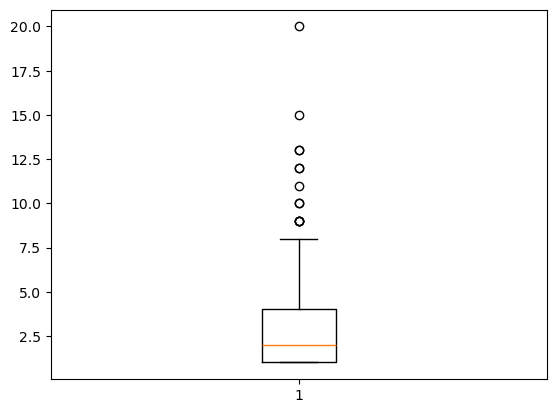

In [40]:
plt.boxplot(SNAP_by_tract.SNAP_count)

In [41]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent'],
      dtype='object')

In [42]:
LBW.columns = ['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
      'census_tract', 'Unnamed: 0', 'ignore','tract',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth Rate', 'Fertility Rate', 'Low_Birth_Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent']

In [43]:
LBW = LBW.merge(SNAP_by_tract,on='census_tract')

In [43]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census_tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth Rate',
       'Fertility Rate', 'Low_Birth_Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'SNAP_count'],
      dtype='object')

I am shifting into creating my map zooming into tracts with 0% LBW to prove our point that it's harder to look at SPA-level data for low birth weight when there are many missing pieces in our data. 

In [55]:
desired_columns = ['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
      'census_tract',
       'sup_dist', 'csa', 'spa', 'Shape__Area', 'Shape__Length',
       
      'Low_Birth_Weight']

In [56]:
LBW['Low_Birth_Weight'] == LBW['Low_Birth_Weight'].fillna(0).astype(int)

0      False
1      False
2      False
3      False
4      False
       ...  
532    False
533     True
534     True
535     True
536     True
Name: Low_Birth_Weight, Length: 537, dtype: bool

In [57]:
LBW[desired_columns].head()

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
0       392  181000  1810.00  4.454338e+07   37799.839553   
1       393  181300  1813.00  1.551066e+07   21437.949799   
2       394  181400  1814.00  9.463031e+06   14429.046463   
3       395  181500  1815.00  1.177897e+07   17895.198610   
4       396  181600  1816.00  1.345468e+07   17952.905094   

                                            geometry census_tract    sup_dist  \
0  POLYGON ((-13157763.792 4049180.565, -13157844...  06037181000  District 1   
1  POLYGON ((-13160041.389 4047497.354, -13160049...  06037181300  District 1   
2  POLYGON ((-13159654.665 4047523.177, -13159779...  06037181400  District 1   
3  POLYGON ((-13157943.906 4047564.065, -13158073...  06037181500  District 1   
4  POLYGON ((-13158195.377 4046409.869, -13158192...  06037181600  District 1   

                        csa            spa   Shape__Area  Shape__Length  \
0  Los Angeles - Eagle Rock  SPA 4 - Metro  4.444900e+07    37014.56487   
1  Los Angeles - Eagle Rock  SPA 4 - Metro  1.560564e+07    19883.49368   
2  Los Angeles - Eagle Rock  SPA 4 - Metro  9.425720e+06    14270.34000   
3  Los Angeles - Eagle Rock  SPA 4 - Metro  1.176077e+07    17618.24516   
4  Los Angeles - Eagle Rock  SPA 4 - Metro  1.336064e+07    17197.12390   

   Low_Birth_Weight  
0              6.04  
1              7.11  
2              3.87  
3              5.93  
4              4.57

In [58]:
LBW[desired_columns].sort_values(by=['Low_Birth_Weight'])

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
536      2494  980038  9800.38  4.861673e+07   42991.767229   
463      1030  275605  2756.05  1.119901e+07   17382.008877   
212       604  207711  2077.11  7.469515e+06   14744.237737   
213       605  207712  2077.12  4.383834e+06    9437.966004   
214       606  207901  2079.01  2.188102e+06    6864.989107   
..        ...     ...      ...           ...            ...   
189       581  206020  2060.20  9.402533e+06   12029.068455   
209       601  207400  2074.00  9.358166e+06   15170.871790   
373       940  265303  2653.03  1.593000e+06    5749.442745   
374       941  265304  2653.04  1.409868e+06    5886.181088   
532      2469  980010  9800.10  4.126462e+07   36580.178340   

                                              geometry census_tract  \
536  POLYGON ((-13176525.692 4030868.156, -13176524...  06037980038   
463  POLYGON ((-13181334.249 4026235.616, -13181240...  06037275605   
212  POLYGON ((-13164565.635 4035017.571, -13164535...  06037207711   
213  POLYGON ((-13164175.126 4034775.208, -13164026...  06037207712   
214  POLYGON ((-13165131.027 4034286.871, -13165054...  06037207901   
..                                                 ...          ...   
189  POLYGON ((-13160942.631 4037163.861, -13160942...  06037206020   
209  POLYGON ((-13162192.637 4035897.187, -13162189...  06037207400   
373  POLYGON ((-13186095.830 4037417.561, -13186066...  06037265303   
374  POLYGON ((-13185932.302 4037436.239, -13185921...  06037265304   
532  POLYGON ((-13160979.700 4039666.452, -13160996...  06037980010   

       sup_dist                               csa            spa  \
536  District 2   Unincorporated - Ladera Heights   SPA 5 - West   
463  District 2         Los Angeles - Playa Vista   SPA 5 - West   
212  District 1            Los Angeles - Downtown  SPA 4 - Metro   
213  District 1            Los Angeles - Downtown  SPA 4 - Metro   
214  District 1            Los Angeles - Downtown  SPA 4 - Metro   
..          ...                               ...            ...   
189  District 1  Los Angeles - Wholesale District  SPA 4 - Metro   
209  District 1            Los Angeles - Downtown  SPA 4 - Metro   
373  District 3            Los Angeles - Westwood   SPA 5 - West   
374  District 3            Los Angeles - Westwood   SPA 5 - West   
532  District 1        Los Angeles - Elysian Park  SPA 4 - Metro   

      Shape__Area  Shape__Length  Low_Birth_Weight  
536  4.852656e+07   42566.840170               0.0  
463  1.123342e+07   17377.222840               0.0  
212  7.428549e+06   14671.256670               0.0  
213  4.383784e+06    9437.955472               0.0  
214  2.128885e+06    6828.323144               0.0  
..            ...            ...               ...  
189  9.395603e+06   11938.556360               NaN  
209  9.422939e+06   15058.800600               NaN  
373  1.594116e+06    5706.964201               NaN  
374  1.394811e+06    5790.897800               NaN  
532  4.157617e+07   34977.576380               NaN  

[537 rows x 13 columns]

Sorting only for LBW rates that are equal to 0. 

In [60]:
LBW0=LBW.loc[LBW['Low_Birth_Weight'] == 0.0]

In [61]:
LBW0.head()

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
22       414  185101  1851.01  8.773447e+06   18663.597141   
23       415  185102  1851.02  1.574638e+07   27682.730203   
52       444  189501  1895.01  3.691370e+06    9296.864585   
53       445  189502  1895.02  2.683325e+06    7299.366956   
56       448  189703  1897.03  3.642446e+07   43353.964436   

                                             geometry census_tract  \
22  POLYGON ((-13158280.870 4043033.224, -13158285...  06037185101   
23  POLYGON ((-13158684.849 4043685.832, -13158708...  06037185102   
52  POLYGON ((-13171121.353 4044027.073, -13171119...  06037189501   
53  POLYGON ((-13172073.358 4043632.723, -13172073...  06037189502   
56  POLYGON ((-13172653.444 4048519.302, -13172678...  06037189703   

    Unnamed: 0      ignore       tract  ... Fertility Rate Low_Birth_Weight  \
22           0  6037185101  6037185101  ...       0.042232              0.0   
23           0  6037185102  6037185102  ...       0.160396              0.0   
52           0  6037189501  6037189501  ...       0.022945              0.0   
53           0  6037189502  6037189502  ...       0.002825              0.0   
56           0  6037189703  6037189703  ...       0.000000              0.0   

   Low Birth Weight Pctl  Average income  Grocery Store Low Access  \
22                   0.0         88400.0                       0.0   
23                   0.0        145088.0                       0.0   
52                   0.0         66071.0                       0.0   
53                   0.0         55694.0                       0.0   
56                   0.0        106970.0                    1814.0   

    Grocery Store Low Access Proportion  CalFresh Cases  CF cases per 100  \
22                             0.000000           212.0              45.3   
23                             0.000000            89.0               9.1   
52                             0.000000           117.0              40.8   
53                             0.000000           261.0             112.0   
56                             0.586296            79.0              27.1   

    PoCPercent  SNAP_count  
22        0.35           2  
23        0.31           1  
52        0.18           1  
53        0.23           2  
56        0.27           1  

[5 rows x 30 columns]

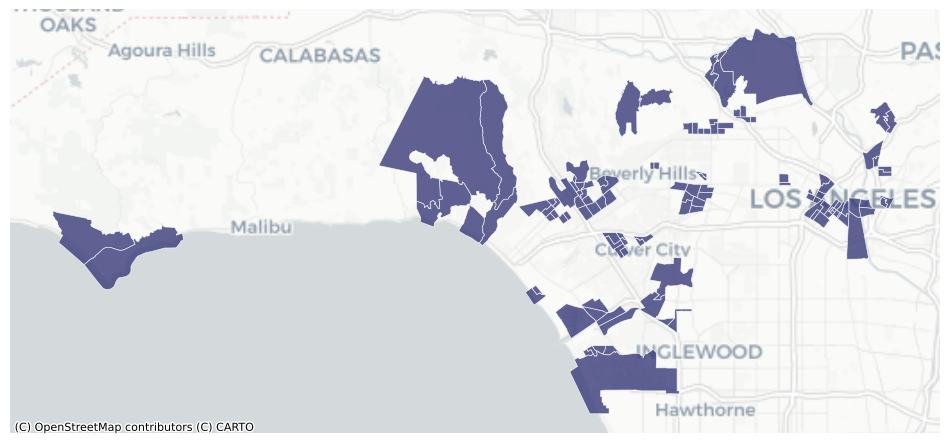

In [62]:
fig, ax = plt.subplots(figsize=(12,12))

LBW0.plot(ax=ax,
         column='Low_Birth_Weight', 
         edgecolor='white',
          cmap= 'tab20b',
         lw=0.5,
         alpha=0.8)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [63]:
minx, miny, maxx, maxy = LBW0.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13230312.829852074
-13158027.061734835
4017570.4117105827
4050500.6479052906


The below leads to making a basemap with the highlighted census tracts, which is a good start for what we want to. I am trying to make a interactive map, eventually. 

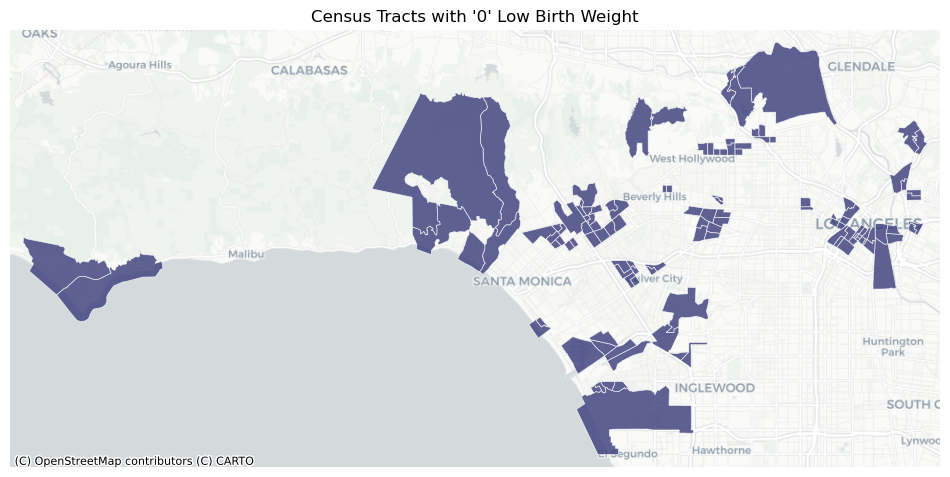

In [64]:
fig, ax = plt.subplots(figsize=(12,12))

LBW0.plot(ax=ax,
         column='Low_Birth_Weight', 
         edgecolor='white',
          cmap= 'tab20b',
         lw=0.5,
         alpha=0.8)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

plt.title("Census Tracts with '0' Low Birth Weight")
            
ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


Reminding myself of the different columns that are in our data set. 

In [66]:
LBW0.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census_tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth Rate',
       'Fertility Rate', 'Low_Birth_Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'SNAP_count'],
      dtype='object')

In [67]:
LBW0.columns = ['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census_tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'Neighborhood/City',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low_Birth_Weight', 'Low Birth Weight Pctl',
       'Median Income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'SNAP_count']

In [68]:
    LBW0.explore(column='Low_Birth_Weight', 
        cmap='tab20b', # 
        scheme='naturalbreaks',
        zoom_start = 11,
        location=[34.03,-118.46],
        tiles='CartoDB positron',
        tooltip='Neighborhood/City',
        highlight=True, 
        legend=False,         
        popup=['Neighborhood/City','Total Population','Total Woman 15-50','PoCPercent', 'Women with births 12 Months','Median Income','Low_Birth_Weight','census_tract'],     
        style_kwds={
            'weight':2,
            'color':'green',
            'opacity':0.6,
            'fillOpacity':0.35
        })

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self._classify()


Great! I am going to move into making my index to aggregate and rank our indicators to become a predictive tool to find areas where high rates of Low Birth Weight may occur. Of our indicators, there are two that actually needed to be ranked in reverse, as a higher value is a social predictor as opposed to a negative one. As a result, my index formula inflates the Median Income and SNAP retailer density to be more accurately reflected in the overall index score. 

Index Indicators: 
- SNAP retailer density
- Median Income
- Proportion of Low-income residents living >1mi from grocery
- Non-white people
- Total Women 15-50

In [69]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'census_tract', 'Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa',
       'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total_Pop', 'Birth Rate',
       'Fertility Rate', 'Low_Birth_Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Low Access',
       'Grocery Store Low Access Proportion', 'CalFresh Cases',
       'CF cases per 100', 'PoCPercent', 'SNAP_count'],
      dtype='object')

Below, I will use the mapclassify library to create my index, first creating a classifier index and using a k value of 5. 

In [70]:
import mapclassify
classifier = mapclassify.NaturalBreaks.make(k=5)

In [71]:
LBW.shape

(537, 30)

In [72]:
LBW.dropna()
LBW.shape

(537, 30)

In [73]:
null_rows = LBW[LBW.isnull().any(axis=1)]
print(null_rows)

     OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
189       581  206020  2060.20  9.402533e+06   12029.068455   
209       601  207400  2074.00  9.358166e+06   15170.871790   
313       705  216301  2163.01  6.069451e+06   11388.509846   
372       939  265301  2653.01  1.717677e+07   20495.487120   
373       940  265303  2653.03  1.593000e+06    5749.442745   
374       941  265304  2653.04  1.409868e+06    5886.181088   
444      1011  273403  2734.03  8.575827e+06   13616.375391   
477      1044  277400  2774.00  6.877749e+06   10438.697565   
531      2468  980009  9800.09  2.288694e+08   81127.024463   
532      2469  980010  9800.10  4.126462e+07   36580.178340   
535      2486  980028  9800.28  2.119243e+08   85718.579965   
536      2494  980038  9800.38  4.861673e+07   42991.767229   

                                              geometry census_tract  \
189  POLYGON ((-13160942.631 4037163.861, -13160942...  06037206020   
209  POLYGON ((-13162192.637 4035897.1

Using the below code to fill in NaN values in the dataset with 0 so they can be properly indexed. 

In [77]:
LBW['Grocery Store Low Access Proportion']= LBW['Grocery Store Low Access Proportion'].fillna(0, inplace=False)
LBW['SNAP_count']= LBW['SNAP_count'].fillna(0)
LBW['Average income']= LBW['Average income'].fillna(0)
LBW['PoCPercent']= LBW['PoCPercent'].fillna(0)

In [78]:
LBW['SNAP_index'] = LBW[['SNAP_count']].apply(classifier)
LBW['grocery_index'] = LBW[['Grocery Store Low Access Proportion']].apply(classifier)
LBW['income_index']=LBW[['Average income']].apply(classifier)
LBW['poc_index']=LBW[['PoCPercent']].apply(classifier)
LBW['woman_index']=LBW[['Total Woman 15-50']].apply(classifier)
LBW.head()

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
0       392  181000  1810.00  4.454338e+07   37799.839553   
1       393  181300  1813.00  1.551066e+07   21437.949799   
2       394  181400  1814.00  9.463031e+06   14429.046463   
3       395  181500  1815.00  1.177897e+07   17895.198610   
4       396  181600  1816.00  1.345468e+07   17952.905094   

                                            geometry census_tract  Unnamed: 0  \
0  POLYGON ((-13157763.792 4049180.565, -13157844...  06037181000           0   
1  POLYGON ((-13160041.389 4047497.354, -13160049...  06037181300           0   
2  POLYGON ((-13159654.665 4047523.177, -13159779...  06037181400           0   
3  POLYGON ((-13157943.906 4047564.065, -13158073...  06037181500           0   
4  POLYGON ((-13158195.377 4046409.869, -13158192...  06037181600           0   

       ignore       tract  ... Grocery Store Low Access Proportion  \
0  6037181000  6037181000  ...                                 0.0   
1  6037181300  6037181300  ...                                 0.0   
2  6037181400  6037181400  ...                                 0.0   
3  6037181500  6037181500  ...                                 0.0   
4  6037181600  6037181600  ...                                 0.0   

  CalFresh Cases CF cases per 100  PoCPercent  SNAP_count  SNAP_index  \
0          289.0             17.3        0.43           3           1   
1          140.0             14.1        0.50           4           2   
2          191.0             19.0        0.53           6           3   
3          152.0             16.2        0.42           2           1   
4          166.0             24.9        0.44           1           0   

   grocery_index  income_index  poc_index  woman_index  
0              0             2          2            1  
1              0             3          2            1  
2              0             2          2            1  
3              0             3          2            1  
4              0             2          2            2  

[5 rows x 35 columns]

In our final index value, we combined the Grocery Access Proportion value with the % of PoC value as well as the amount of birthing women per tract. Then we multiply the amount of SNAP retailers per tract by 2 and then multiply the income index by 3. These two values are added and then subtracted from the aggregated score. This helps to put an emphasis on the number of retailers and income, which are significant indicators but can affect the index score as they are ranked positively. The hope with the index is to give higher values to more disadvantaged areas that need more outreach, and adding the income and SNAP index would incorrectly inflate values, not allowing us to focus on communities that need it the most. This way, the most advantaged communities may be in the negatives but are no longer prioritized for support as needed. 

In [79]:
LBW['final_index']= LBW['grocery_index'] + LBW['poc_index'] + LBW['woman_index']- (2*LBW['SNAP_index']) - (3*LBW['income_index'])
LBW.head()

OBJECTID    CT20    LABEL   ShapeSTArea  ShapeSTLength  \
0       392  181000  1810.00  4.454338e+07   37799.839553   
1       393  181300  1813.00  1.551066e+07   21437.949799   
2       394  181400  1814.00  9.463031e+06   14429.046463   
3       395  181500  1815.00  1.177897e+07   17895.198610   
4       396  181600  1816.00  1.345468e+07   17952.905094   

                                            geometry census_tract  Unnamed: 0  \
0  POLYGON ((-13157763.792 4049180.565, -13157844...  06037181000           0   
1  POLYGON ((-13160041.389 4047497.354, -13160049...  06037181300           0   
2  POLYGON ((-13159654.665 4047523.177, -13159779...  06037181400           0   
3  POLYGON ((-13157943.906 4047564.065, -13158073...  06037181500           0   
4  POLYGON ((-13158195.377 4046409.869, -13158192...  06037181600           0   

       ignore       tract  ... CalFresh Cases CF cases per 100 PoCPercent  \
0  6037181000  6037181000  ...          289.0             17.3       0.43   
1  6037181300  6037181300  ...          140.0             14.1       0.50   
2  6037181400  6037181400  ...          191.0             19.0       0.53   
3  6037181500  6037181500  ...          152.0             16.2       0.42   
4  6037181600  6037181600  ...          166.0             24.9       0.44   

   SNAP_count  SNAP_index  grocery_index  income_index  poc_index  \
0           3           1              0             2          2   
1           4           2              0             3          2   
2           6           3              0             2          2   
3           2           1              0             3          2   
4           1           0              0             2          2   

   woman_index  final_index  
0            1           -5  
1            1          -10  
2            1           -9  
3            1           -8  
4            2           -2  

[5 rows x 36 columns]

Pulling a preliminary plot below to test our access and make sure certain areas are the ones that are being addressed.

<Axes: >

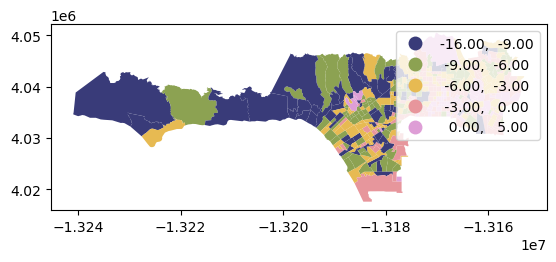

In [81]:
LBW.plot(column='final_index',
         linewidth=0,
         scheme='Natural_Breaks',
         cmap='tab20b',
         legend=True)

Making an interactive Folium based map for our tracts with zero LBW.

In [85]:
m  = folium.Map(location=[34.03,-118.46], 
               zoom_start = 11,
               tiles='CartoDB positron', 
               attribution='CartoDB')
cp= folium.Choropleth(
                  geo_data=LBW, # geo data
                  data=LBW, # data          
                  key_on='feature.properties.census_tract', # key, or merge column
                  columns=['census_tract', 'final_index'], # [key, value]
                  fill_color='Purples_r',
                  line_weight=0.5, 
                  fill_opacity=0.6,
                  line_opacity=.8, # line opacity (of the border)
                  legend_name='Final Index').add_to(m)
m

In [86]:
folium.GeoJsonTooltip(['csa','final_index'],aliases=['City/Neighborhood Name:','Index Score']).add_to(cp.geojson)
m.save('LBW_index.html')

Code below is for pulling value for map in ARCGiS for average values on our LBW community story map. I've collapsed them to make them cleaner for our overall piece.

In [210]:
LBW['csa'].value_counts()

csa
Los Angeles - Hollywood             23
Los Angeles - Boyle Heights         23
Los Angeles - Melrose               22
City of Santa Monica                19
Los Angeles - Westwood              18
                                    ..
Los Angeles - Mandeville Canyon      1
Los Angeles - Cloverdale/Cochran     1
Los Angeles - Lafayette Square       1
Los Angeles - St Elmo Village        1
Unincorporated - West LA             1
Name: count, Length: 79, dtype: int64

In [213]:
SNAP_neigh=LBW.groupby('csa')[['SNAP_count']].mean()

In [91]:
pd.set_option('display.max_rows', None)

In [92]:
SNAP_gro=LBW.groupby('csa')[['Grocery Store Low Access Proportion']].mean()

In [93]:
SNAP_lad=LBW.groupby('csa')[['Total Woman 15-50']].mean()

And that's my work for the final! 